# Chapter7
## Model Performance and Validation

In [1]:
import os, sys
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from dataset_simulation import DatasetSimulation
from cfar_detector import CFARDetector
from nn_detector import NeuralNetworkDetector
from yolo_detector import YOLODetector
from detector_generator import DetectorGenerator


dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

In [2]:
files = database.get_train()

### Cross-Correlation using Whistler Kernel (CCWK)

(35, 648) (36, 103)


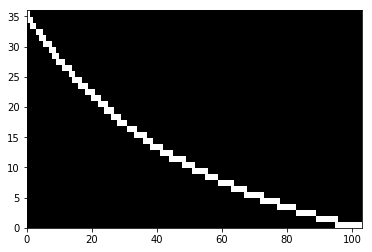

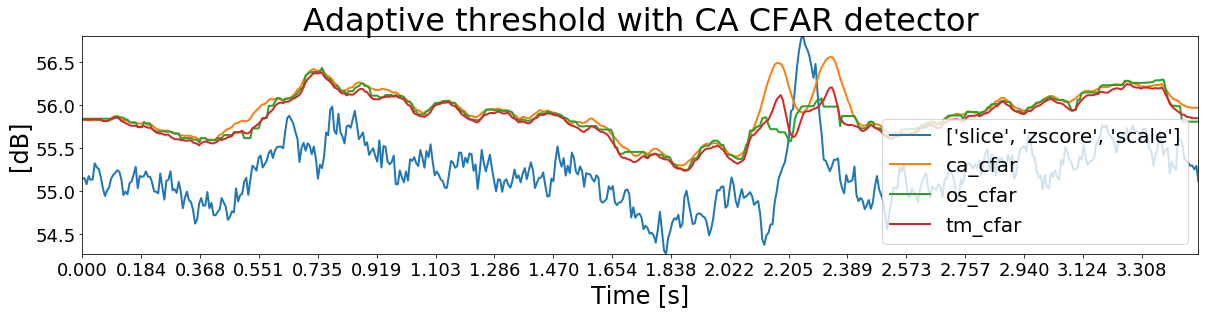

[['2.251' '56.805']]


In [24]:
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
N,G,X = 10, 7, 0.7
pfa = (1/(1+((10**(X/10))/(2*N))))**(2*N)
k, Ts, Tl = N-1, floor(0.3*N), floor(0.7*N)
fmin, fmax = 2.5, 8
f = np.linspace(fmin*1e3, fmax*1e3, 1000)
dataset_sim.set_frequency_range(f)
kernel = dataset_sim.whistler_sim(An=0.35, D0=80, magnitude=1)
plt.pcolormesh(kernel, cmap='gray')
# plt.figure()
# kernel = dataset_sim.whistler_sim_D0(An=0.35, D0=np.linspace(20,80,50), magnitude=1)
# plt.pcolormesh(kernel, cmap='gray')

file = np.random.choice(files)
# file = '2013-07-19UT04:14:42.00291922.marion.vr2'
transforms, transforms_params = ['slice', 'zscore', 'scale'], [[fmin,fmax],None,[0,1]]
sample = CFARDetector(dataset_loc, site, file)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
sample.apply_transform(transforms, transforms_params)
print(sample.get_spectrogram().shape, kernel.shape)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
sample.plot_corr_output([transforms], [transforms_params], ['ca_cfar','os_cfar','tm_cfar'], [[N,G,pfa],[N,G,k,pfa],[N,G,Ts,Tl,pfa]], kernel=kernel, 
                            thresholds=[], detection=True, figsize=sample.get_figsize(), title='Adaptive threshold with CA CFAR detector',font=font)
print(sample.detection_starting_locations(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,Ts,Tl,pfa]))

2013-06-26UT09:47:41.52291930.marion.vr2
awda whislters
[[  2.319081 231.      ]
 [  2.367081  38.      ]
 [  4.383081  89.      ]]
[[  2.3 231. ]
 [  2.4  38. ]
 [  4.4  89. ]]


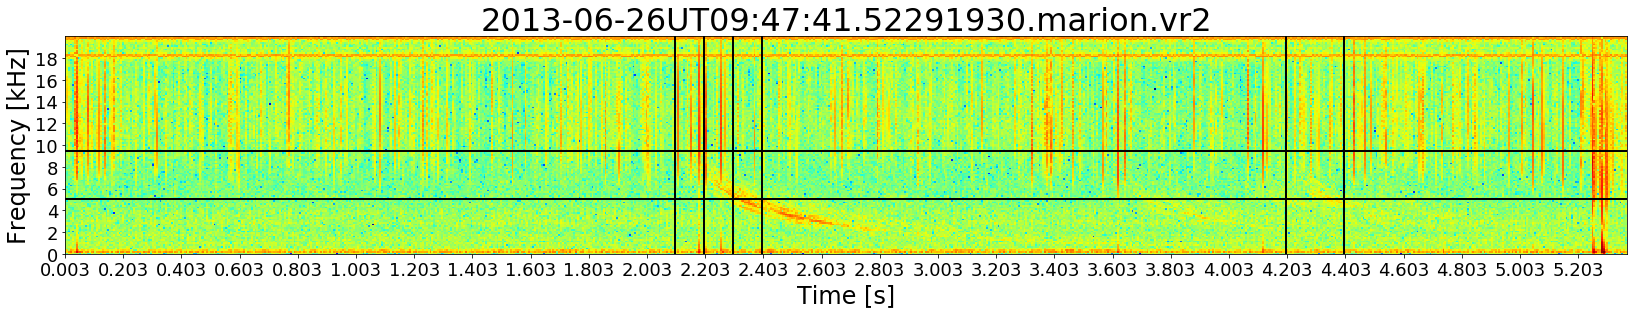

0.006396190476190476


In [12]:
transforms, transforms_params = [None], [None]
# transforms, transforms_params = ['slice', 'zscore','scale'], [[1.5,9.5],None,[0,1]]
file = np.random.choice(files)
# file = '2013-07-19UT04:14:42.00291922.marion.vr2'
print(file)
sample = Sample(dataset_loc, site, file)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
sample.apply_transform(transforms, transforms_params)

print('awda whislters')
awd_outputs = sample.awda_whistlers(time_err=10, threshold=30)[0]
print(awd_outputs)
awd_outputs = sample.awda_whistlers(time_err=1, threshold=30)[0]
print(awd_outputs)
awd_outputs = np.concatenate((np.array([o[0] for o in awd_outputs]),np.array([o[0]-0.2 for o in awd_outputs])))
sample.spectrogram_plot(figsize=sample.get_figsize() , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                               xaxis=True, yaxis=True,ticks=[0.2,2], title=sample.get_file(), cmap='jet', 
                        vlines=awd_outputs,hlines=[5,9.5],cmap_show=False, font=font,output=[])
print(sample.get_time_res())